# 09. PyTorch Model Deployment

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

Resources:
- Book version of notebook: https://www.learnpytorch.io/09_pytorch_model_deployment/
- Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorch_model_deployment.pdf

## 0. Get setup


In [1]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.0+cu124
torchvision version: 0.20.0+cu124


In [5]:
from torch import nn
from torchvision import transforms

from torchinfo import summary

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [11]:
! ls going_modular/going_modular


data_setup.py  model_builder.py  __pycache__  train.py
engine.py      predictions.py	 README.md    utils.py


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 
     

'cuda'

## 1. Getting Data
The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

We can get data with code from: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [10]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path
     

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [13]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir
     


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

>3 questions:
>- What is my most ideal machine learning model deployment scenario?
>- Where is my model going to go?
>- How is my model going to function?

>FoodVision Mini ideal use case: A model that performs well and fast.
>- Performs well: 95%+ accuracy
>- Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
>
>(Latency = time for prediction to take place)

>To try and achieve these goals, we're going to build two model experiments:
>- EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
>- ViT feature extractor (just like in 08. PyTorch Paper Replicating)

## 3. Creating an EffNetB2 feature extractor
Feautre extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [16]:
effnetb2_weights= torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms= effnetb2_weights.transforms()
effnetb2= torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad=False

In [21]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=11,
        row_settings=["var_names"])
     

Layer (type (var_name))                                      Input Shape Output Shape Param #     Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 1000]   --          False
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --          False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --          False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)       False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)        False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --          --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --          False
│    │    └─MBConv (0)                                       [1, 32, 112, 112] [1, 16, 112, 112] (1,44

In [22]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [24]:
set_seeds()

effnetb2.classifier= nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3))


In [25]:
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=11,
        row_settings=["var_names"])
     

Layer (type (var_name))                                      Input Shape Output Shape Param #     Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 3]      --          Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --          False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --          False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)       False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)        False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --          --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --          False
│    │    └─MBConv (0)                                       [1, 32, 112, 112] [1, 16, 112, 112] (1,

### 3.1 Creating a function to make an EffNetB2 feature extractor


In [26]:
def create_effnetb2_model(num_classes:int=3,seed:int=42):
    
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms
     

In [27]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,seed=42)

In [31]:
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=10,
#         row_settings=["var_names"])
     

### 3.2 Creating DataLoaders for EffNetB2


In [32]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
                                                                     train_dir=train_dir,
                                                                     test_dir=test_dir,
                                                                     transform=effnetb2_transforms,
                                                                     batch_size=32)
     
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names


(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor


In [38]:
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=effnetb2.parameters(),lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn, 
                                device=device)
     


Epoch: 1 | train_loss: 0.9884 | train_acc: 0.5500 | test_loss: 0.7394 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7132 | train_acc: 0.8583 | test_loss: 0.5780 | test_acc: 0.9318
Epoch: 3 | train_loss: 0.5799 | train_acc: 0.8979 | test_loss: 0.4813 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4636 | train_acc: 0.8917 | test_loss: 0.4281 | test_acc: 0.9437
Epoch: 5 | train_loss: 0.4290 | train_acc: 0.8917 | test_loss: 0.3893 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4111 | train_acc: 0.9042 | test_loss: 0.3510 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4267 | train_acc: 0.8542 | test_loss: 0.3205 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.4196 | train_acc: 0.8958 | test_loss: 0.3369 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3661 | train_acc: 0.8833 | test_loss: 0.3098 | test_acc: 0.9347
Epoch: 10 | train_loss: 0.3537 | train_acc: 0.8688 | test_loss: 0.2787 | test_acc: 0.9563


### 3.4 Inspecting EffNetB2 loss curves

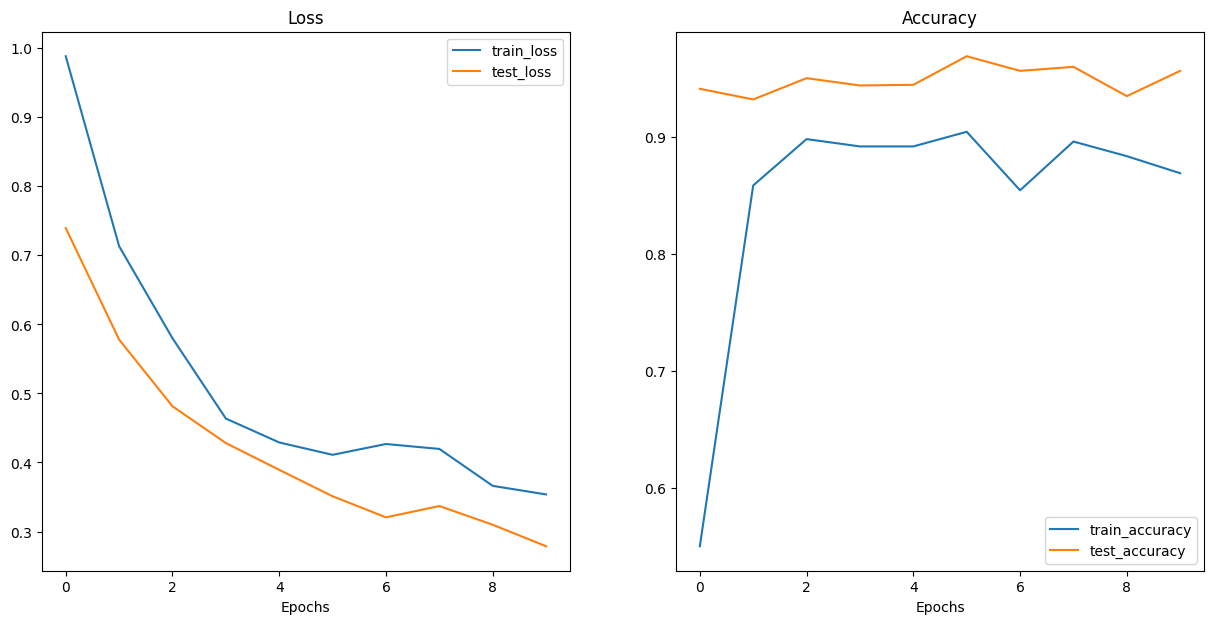

In [40]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)


See here for what an ideal loss curve should look like: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like



### 3.5 Saving EffNetB2 feature extractor

In [41]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor
Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [48]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")
     

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats


In [50]:
torch.numel(torch.tensor([1,2,3]))

3

In [52]:
sum(torch.numel(param) for param in effnetb2.parameters())

7705221

In [70]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [83]:
[torch.numel(param) for param in effnetb2.parameters()]

[864,
 32,
 32,
 288,
 32,
 32,
 256,
 8,
 256,
 32,
 512,
 16,
 16,
 144,
 16,
 16,
 64,
 4,
 64,
 16,
 256,
 16,
 16,
 1536,
 96,
 96,
 864,
 96,
 96,
 384,
 4,
 384,
 96,
 2304,
 24,
 24,
 3456,
 144,
 144,
 1296,
 144,
 144,
 864,
 6,
 864,
 144,
 3456,
 24,
 24,
 3456,
 144,
 144,
 1296,
 144,
 144,
 864,
 6,
 864,
 144,
 3456,
 24,
 24,
 3456,
 144,
 144,
 3600,
 144,
 144,
 864,
 6,
 864,
 144,
 6912,
 48,
 48,
 13824,
 288,
 288,
 7200,
 288,
 288,
 3456,
 12,
 3456,
 288,
 13824,
 48,
 48,
 13824,
 288,
 288,
 7200,
 288,
 288,
 3456,
 12,
 3456,
 288,
 13824,
 48,
 48,
 13824,
 288,
 288,
 2592,
 288,
 288,
 3456,
 12,
 3456,
 288,
 25344,
 88,
 88,
 46464,
 528,
 528,
 4752,
 528,
 528,
 11616,
 22,
 11616,
 528,
 46464,
 88,
 88,
 46464,
 528,
 528,
 4752,
 528,
 528,
 11616,
 22,
 11616,
 528,
 46464,
 88,
 88,
 46464,
 528,
 528,
 4752,
 528,
 528,
 11616,
 22,
 11616,
 528,
 46464,
 88,
 88,
 46464,
 528,
 528,
 13200,
 528,
 528,
 11616,
 22,
 11616,
 528,
 63360,
 120,

In [71]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.27869718074798583,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

In [75]:
effnetb2_results['test_loss']

[0.7394458293914795,
 0.5780010402202607,
 0.4813401520252228,
 0.42810977101325987,
 0.38934711217880247,
 0.3510460495948792,
 0.32053725719451903,
 0.3369010418653488,
 0.3097884088754654,
 0.27869718074798583]

In [84]:
effnetb2_results['test_loss'][-1]

0.27869718074798583

## 4. Creating a ViT feature extractor
We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor, see here for ideas: https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset



In [91]:
vit=torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [96]:
def create_vit_model(num_lasses:int=3, seed:int=42):
    weights= torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms= weights.transforms()
    model= torchvision.models.vit_b_16(weights=weights)
    
    for param in model.parameters():
        param.requires_grad=False
    
    torch.manual_seed(seed)
    model.heads=nn.Sequential(
        nn.Linear(in_features=768, out_features=num_lasses))
    
    return model, transforms



In [104]:
vit, vit_transforms=create_vit_model(num_lasses=3)
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [105]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [102]:
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=13,
        row_settings=["var_names"])
     

Layer (type (var_name))                                      Input Shape   Output Shape  Param #       Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]        768           Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)     False
├─Encoder (encoder)                                          [1, 197, 768] [1, 197, 768] 151,296       False
│    └─Dropout (dropout)                                     [1, 197, 768] [1, 197, 768] --            --
│    └─Sequential (layers)                                   [1, 197, 768] [1, 197, 768] --            False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768] [1, 197, 768] (7,087,872)   False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768] [1, 197, 768] (7,087,872)   False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768] [1, 197, 768] (7,087,872)   False
│    │ 

### 4.1 Creating DataLoaders for ViT feature extractor


In [103]:
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names
     

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extractor


In [106]:
from going_modular.going_modular import engine

optimizer= torch.optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn=nn.CrossEntropyLoss()

set_seeds()
vit_results= engine.train(model=vit,
                         train_dataloader=train_dataloader_vit,
                         test_dataloader=test_dataloader_vit,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=10,
                         device=device)

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor


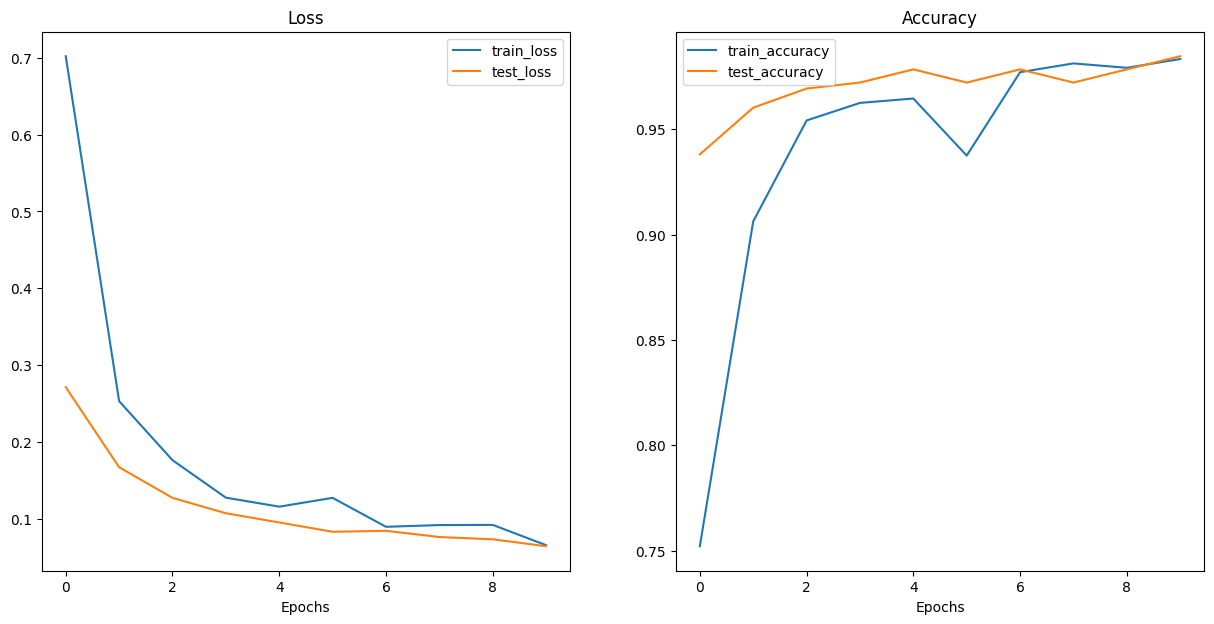

In [107]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

For more on what an ideal loss curves should look like see here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 4.4 Saving ViT feature extractor


In [108]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                target_dir="models",
                model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor


In [113]:
from pathlib import Path

pretrained_vit_model_size=Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size/(1024*1024)
print(f"Pretrained ViT feature extractor model size: {round(pretrained_vit_model_size, 2)} MB")

Pretrained ViT feature extractor model size: 327.37 MB


### 4.6 Collecting ViT feature extractor stats


In [118]:
vit_total_params= sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [121]:
vit_stats={'test_loss':vit_results['test_loss'][-1],
          'test_acc':vit_results['test_acc'][-1],
          'number_of_parameters':vit_total_params,
          'model_size (MB)':pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443450534716248,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887}

In [120]:
effnetb2_stats

{'test_loss': 0.27869718074798583,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

## 5. Making predictions with our trained models and timing them

Our goal:

- Performs well (95%+ test accuracy)
- Fast (30+FPS)

To test criteria two:

- Loop through test images
- Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths.

In [122]:
from pathlib import Path

test_dir

PosixPath('data/pizza_steak_sushi_20_percent/test')

In [147]:
test_data_path= list(Path(test_dir).glob('*/*.jpg'))
test_data_path[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2549661.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/724290.jpg')]

In [163]:
test_data_path[0]

PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg')

In [171]:
test_data_path[0].name

'648055.jpg'

In [172]:
test_data_path[0].stem

'648055'

In [161]:
test_data_path[0].parent

PosixPath('data/pizza_steak_sushi_20_percent/test/pizza')

In [169]:
test_data_path[0].parent.name

'pizza'

In [173]:
test_data_path[0].parent.stem

'pizza'

In [177]:
test_data_path[0].parent.parent.name

'test'

In [181]:
test_data_path[0].parent.parent.stem

'test'

### 5.1 Creating a function to make prediction across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms, a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [216]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

# 1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms,
#a list of target class names and a target device.
def pred_and_store(paths:list[pathlib.Path],
                  transform:torchvision.transforms,
                  model:torch.nn.Module,
                  class_names:list[str],
                  device:str= 'cuda' if torch.cuda.is_available() else 'cpu')->list[dict]:
    
    # 2. Create an empty list (can return a full list of all predictions later)
    pred_list=[]
    
    # 3. Loop through the target input paths (the rest of the steps will take place inside the loop)
    for path in tqdm(paths):
        
        # 4. Create an empty dictionary for each sample (prediction statistics will go in here)
        pred_dict={}
        
        # 5. Get the sample path and ground truth class from the filepath
        pred_dict['image_path']=path
        class_name=path.parent.stem
        #print(class_name)
        pred_dict['class_names']=class_name
        
        # 6. Start the prediction timer
        start_time=timer()
        
        # 7. Open the image using PIL.Image.open(path)
        image= Image.open(path)
        
        # 8. Transform the image to be usable with a given model (also add batch dimention and send to target device)
        transformed_image=transform(image).unsqueeze(0).to(device)
        
        # 9. Prepare the model model for inference by sending to the target device and turning on eval() mode
        model=model.to(device)
        model.eval()
        
        # 10. Turn on torch.inference_mode() and pass the target transformed image to the model and
        #perform forward pass + calculate pred prob + pred class
        
        with torch.inference_mode():
            pred_logit=model(transformed_image)
            pred_prob=torch.softmax(pred_logit, dim=1)
            pred_label=torch.argmax(pred_prob, dim=1)
            pred_class=class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)
            
            # 11. Add the pred prob + pred class to empty dictionary from step 4
            pred_dict['pred_prob']=round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict['pred_class']=pred_class

            # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary
            end_time=timer()
            pred_dict['time_for_pred']=round(end_time-start_time, 4)

        # 13. See if the predicted class matches the ground truth class
        pred_dict['correct']= class_name==pred_class

        # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2
        pred_list.append(pred_dict)

    # 15. Return the list of prediction dictionaries
    return pred_list
        
            

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:

- Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
- Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`)


In [217]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts= pred_and_store(paths=test_data_path,
                                        transform=effnetb2_transforms,
                                        model=effnetb2,
                                        class_names=class_names,
                                        device='cpu') # Hard code predictions to happen on CPU

100%|█████████████████████████████████████████| 150/150 [00:21<00:00,  7.04it/s]


In [219]:
effnetb2_test_pred_dicts[0:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.8569,
  'pred_class': 'pizza',
  'time_for_pred': 0.2425,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2549661.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.9717,
  'pred_class': 'pizza',
  'time_for_pred': 0.126,
  'correct': True}]

In [223]:
# Turn effnetb2_the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_names,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.8569,pizza,0.2425,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9717,pizza,0.1260,True
2,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7035,pizza,0.1352,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8489,pizza,0.1442,True
4,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7804,pizza,0.1427,True


In [244]:
# Check number of correct predictions
#sum(effnetb2_test_pred_df['class_names']==effnetb2_test_pred_df['pred_class'])
#effnetb2_test_pred_df.correct.sum()
effnetb2_test_pred_df.correct.value_counts()

correct
True     143
False      7
Name: count, dtype: int64

In [260]:
# Find the average time per prediction 
effnetb2_average_time_per_pred= round(effnetb2_test_pred_df.time_for_pred.mean(),4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1407


Note: Prediction times will vary (much like training times) depending on the hardware you're using... so generally the faster your compute (e.g. CPU or GPU), the faster the predictions will happen.

In [254]:
effnetb2_test_pred_df.time_for_pred.mean()

np.float64(0.140718)

In [256]:
effnetb2_test_pred_df.time_for_pred.sum()/len(effnetb2_test_pred_df)

np.float64(0.140718)

In [250]:
len(effnetb2_test_pred_df)

150

In [261]:
effnetb2_stats

{'test_loss': 0.27869718074798583,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

In [262]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred 
effnetb2_stats
     

{'test_loss': 0.27869718074798583,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': np.float64(0.1407)}

### 5.3 Making and timing predictions with ViT

In [264]:
# Make list of prediction dictionaries with ViT feature extractor model on test images 
vit_test_pred_dicts = pred_and_store(paths=test_data_path,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # hardcode device to CPU because not sure if GPU available when we deploy 
     

100%|█████████████████████████████████████████| 150/150 [01:03<00:00,  2.34it/s]


In [266]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.9969,
  'pred_class': 'pizza',
  'time_for_pred': 0.8591,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2549661.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.9977,
  'pred_class': 'pizza',
  'time_for_pred': 0.3691,
  'correct': True}]

In [267]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()
     

,image_path,class_names,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.9969,pizza,0.8591,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9977,pizza,0.3691,True
2,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9732,pizza,0.4571,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9983,pizza,0.3971,True
4,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9946,pizza,0.5416,True


In [268]:
# See how many correct
vit_test_pred_df.correct.value_counts()
     

correct
True     148
False      2
Name: count, dtype: int64

In [269]:

# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")
     

ViT average time per prediction: 0.4254


In [270]:
vit_stats

{'test_loss': 0.06443450534716248,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887}

In [271]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats
     


{'test_loss': 0.06443450534716248,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': np.float64(0.4254)}

## 6. Comparing model results, prediction times and size

In [274]:
df=pd.DataFrame([effnetb2_stats,vit_stats])
df['model']=['EffNetB2','ViT']
df['test_acc']=round(df['test_acc']*100,2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.278697,95.62,7705221,29.863886,0.1407,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.4254,ViT


Which model is better?

- `test_loss` (lower is better) - ViT
- `test_acc` (higher is better) - ViT
- `number_of_parameters` (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
    - sometimes models with higher parameters can still perform fast
- `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
- `time_per_pred_cpu` (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2
Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.

In [279]:
df.set_index('model')

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
model,,,,,
EffNetB2,0.278697,95.62,7705221,29.863886,0.1407
ViT,0.064435,98.47,85800963,327.370970,0.4254


In [290]:
df.set_index('model').loc['ViT']


test_loss               6.443451e-02
test_acc                9.847000e+01
number_of_parameters    8.580096e+07
model_size (MB)         3.273710e+02
time_per_pred_cpu       4.254000e-01
Name: ViT, dtype: float64

In [296]:
df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]

test_loss                0.231199
test_acc                 1.029805
number_of_parameters    11.135432
model_size (MB)         10.962102
time_per_pred_cpu        3.023454
dtype: float64

In [294]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.231199,1.029805,11.135432,10.962102,3.023454


### 6.1 Visualizing the speed vs. performance tradeoff
So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:

- Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
- Add titles and labels to make our plot look nice.
- Annotate the samples on the scatter plot so we know what's going on.
- Create a legend based on the model sizes (model_size (MB)).

In [297]:
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.278697,95.62,7705221,29.863886,0.1407,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.4254,ViT


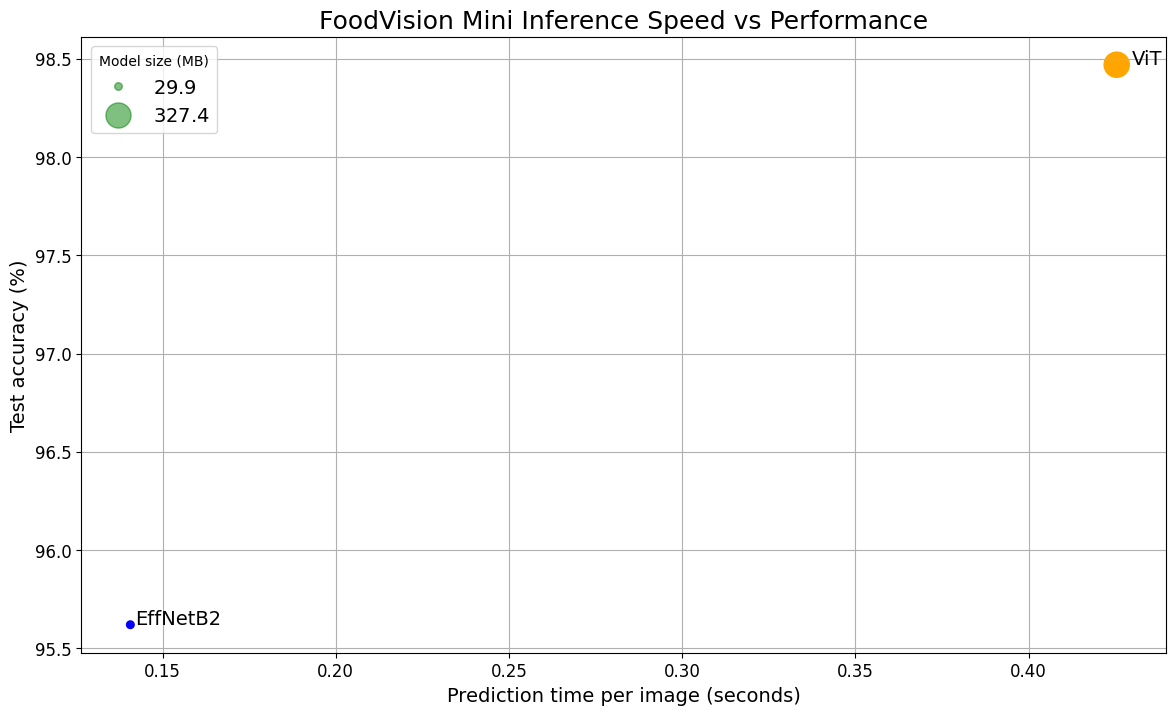

In [379]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
scatter=plt.scatter(data=df,
            x='time_per_pred_cpu',
            y='test_acc',
            s='model_size (MB)',
            c=['blue','orange'])

# 2. Add titles and labels to make our plot look good
plt.title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
plt.xlabel("Prediction time per image (seconds)", fontsize=14)
plt.ylabel("Test accuracy (%)", fontsize=14)
plt.tick_params(axis="both", labelsize=12)
plt.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on. 
for index,row in df.iterrows():
    plt.annotate(text=row['model'],
                xy=(row['time_per_pred_cpu']*1.01,row['test_acc']),
                size=14)

# 4. Create a legend based on the model sizes (model_size (MB))
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5,c='g')
plt.legend(handles,
           labels,
           title='Model size (MB)',
           fontsize=14)

plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.png")


In [332]:
for index, row in df.iterrows():
    print(index,'\n',row)

0 
 test_loss                0.278697
test_acc                    95.62
number_of_parameters      7705221
model_size (MB)         29.863886
time_per_pred_cpu          0.1407
model                    EffNetB2
Name: 0, dtype: object
1 
 test_loss                0.064435
test_acc                    98.47
number_of_parameters     85800963
model_size (MB)         327.37097
time_per_pred_cpu          0.4254
model                         ViT
Name: 1, dtype: object


In [349]:
100*1.1

110.00000000000001

In [361]:
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
handles,labels


([<matplotlib.lines.Line2D at 0x7520b7228800>,
 ['$\\mathdefault{29.9}$', '$\\mathdefault{327.4}$'])